In [1]:
%load_ext autoreload
%autoreload 2
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
#    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
#    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
#    'FranoisTARANTIN': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
#    'GrenobleNvAir': 'Grenoble Nouvel Air',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',    
}

In [3]:
filename = 'data.csv'
if not os.path.isfile(filename):
    df = pandas.concat([tw.get_data(user, n=200, tag=tag) for user, tag in users.items()])
    df.to_csv(filename, index=False)
else:
    df = pandas.read_csv(filename)
    df['date'] = pandas.to_datetime(df['date'])
df = df[df['date'] >= pandas.to_datetime('2019-09-01')]
print(len(df), len(df.columns))

805 10


In [4]:
df.sample(n=10)

,name,login,likes,retweets,text,date,in_reply,source,coordinates,geo
61,Éric Piolle,EricPiolle,145,61,"🌹Merci Anne, pour ton beau soutien. Partout le...",2019-11-29 10:05:36,NaN,Twitter for Android,NaN,NaN
1067,Olivier Noblecourt,onoblecourt,5,3,Un engagement avec des moyens doublés dans le ...,2019-10-16 08:54:38,NaN,Twitter for iPhone,NaN,NaN
274,Emilie CHALAS,EmilieCChalas,16,0,Visite de l’association AVIPAR qui œuvre pour ...,2020-01-13 20:06:48,NaN,Twitter for iPhone,NaN,NaN
249,Emilie CHALAS,EmilieCChalas,27,11,"Oui il reste beaucoup à faire, mais oui, loin ...",2020-01-25 14:02:07,NaN,Twitter for iPhone,NaN,NaN
86,Éric Piolle,EricPiolle,17,10,"Pour votre sécurité, des contrôles sont faits ...",2019-10-24 15:34:28,NaN,Twitter Web App,NaN,NaN
82,Éric Piolle,EricPiolle,320,97,"La @FranceInsoumise apporte, à son tour, son é...",2019-10-30 13:12:34,NaN,Twitter Web App,NaN,NaN
654,Alain Carignon,CarignonAlain,27,8,🙏Très sensible au soutien de Mimoun M’Rad qui ...,2019-12-24 05:54:19,NaN,Twitter for iPhone,NaN,NaN
1055,Olivier Noblecourt,onoblecourt,7,2,Cher @Manuel_Domergue merci d'éviter les affir...,2019-11-08 16:47:27,NaN,Twitter for Android,NaN,NaN
1061,Olivier Noblecourt,onoblecourt,51,26,"Olivier Noblecourt : ""on a fait porter sur les...",2019-10-18 07:13:45,NaN,Twitter for iPhone,NaN,NaN
343,Emilie CHALAS,EmilieCChalas,21,5,Oui @Arnaud_Beaumont !!\nMenons cette campagne...,2019-12-07 20:33:18,NaN,Twitter for iPhone,NaN,NaN


/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 16 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/figure.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


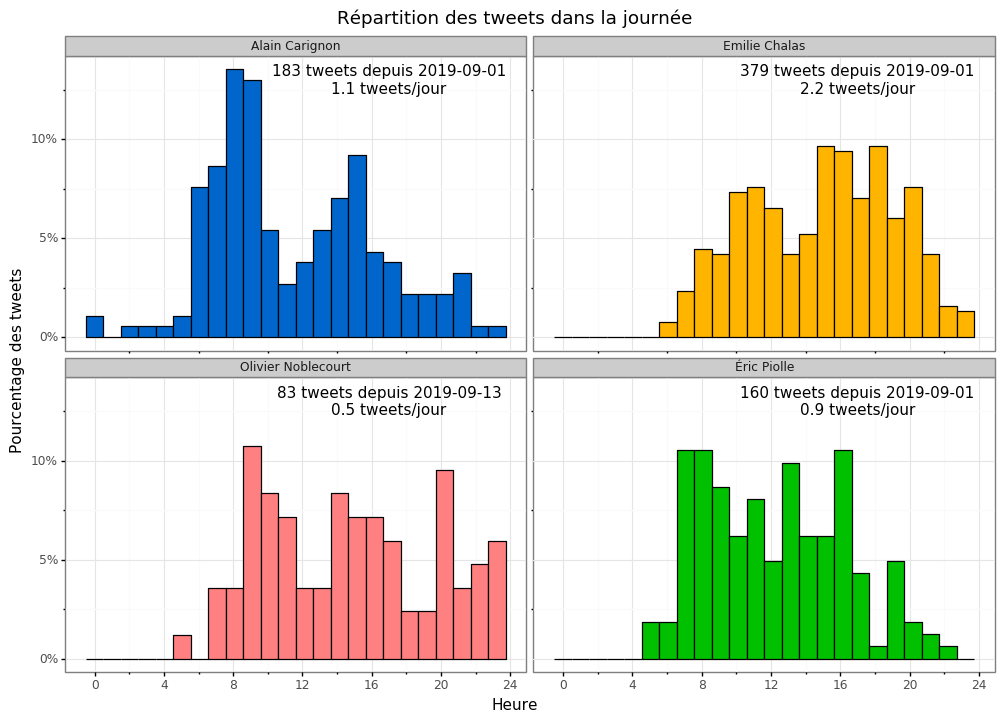

<ggplot: (-9223363282429149191)>

In [5]:
from mizani.formatters import percent_format

def format_text(row):
    return f'{row["count"]} tweets depuis {row["min"]}\n{row["intensity"]:.1f} tweets/jour'

def format_name(row):  # some candidates write their names in all-caps...
    names = row['name'].lower().split()
    names = [f'{n[0].upper()}{n[1:]}' for n in names]
    return ' '.join(names)

df['tag'] = df.apply(lambda row: users[row['login']], axis=1)
df['name'] = df.apply(format_name, axis=1)

tmp = df.groupby('name')[['date']].agg(['min', 'max', 'count']).reset_index(col_level=1)
tmp.columns = tmp.columns.droplevel()
tmp['intensity'] = tmp['count'] / (tmp['max'] - tmp['min']).dt.days
tmp['min'] = tmp['min'].dt.date
tmp['max'] = tmp['max'].dt.date
tmp['text'] = tmp.apply(format_text, axis=1)
tmp

df['time'] = pandas.to_timedelta(df['date'].dt.time.astype(str)).dt.total_seconds() / 3600  # some dirty hack
plot = ggplot(df) +\
    geom_histogram(aes(x='time', fill='tag', y='..density..'), color='black', bins=24) +\
    theme_bw() +\
    scale_fill_manual(colors) +\
    xlab('Heure') +\
    ylab('Pourcentage des tweets') +\
    labs(fill='Mouvement') +\
    facet_wrap('name') +\
    theme(legend_position='none') +\
    scale_x_continuous(breaks=range(0, 25, 4)) +\
    scale_y_continuous(labels = percent_format()) +\
    geom_text(tmp, aes(label='text'), x=17, y=0.13) +\
    ggtitle('Répartition des tweets dans la journée')

plot.save('/tmp/figure.png', width=16, height=10)

plot

In [6]:
df.groupby('name')[['date']].agg(['min', 'count'])

date      
                                   min count
name                                        
Alain Carignon     2019-09-01 15:13:10   183
Emilie Chalas      2019-09-01 15:41:58   379
Olivier Noblecourt 2019-09-13 07:52:23    83
Éric Piolle        2019-09-01 06:54:52   160

In [7]:
df.groupby(['name', 'source'])[['date']].count()

date
name               source                   
Alain Carignon     TweetDeck               6
                   Twitter Web App        28
                   Twitter for iPhone    149
Emilie Chalas      Twitter Web App        16
                   Twitter for iPhone    363
Olivier Noblecourt Twitter Web App         4
                   Twitter Web Client      5
                   Twitter for Android    11
                   Twitter for Mac         3
                   Twitter for iPad       15
                   Twitter for iPhone     45
Éric Piolle        Twitter Web App        64
                   Twitter for Android    96

In [8]:
tmp = tw.get_mentions(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name               mention               
Emilie Chalas      @EricPiolle         23
Olivier Noblecourt @GrenobleNvAir      21
Alain Carignon     @EricPiolle         17
Emilie Chalas      @AN_ComLois         15
                   @AssembleeNat       15
Alain Carignon     @teleGrenoble       14
Emilie Chalas      @MarleneSchiappa    13
                   @VilledeGrenoble    12
                   @gouvernementFR     11
Alain Carignon     @JJBourdin_RMC      11
Emilie Chalas      @OlgaGivernet        9
                   @m_chamussy          8
                   @bleu_isere          7
Alain Carignon     @ledauphine          7
Emilie Chalas      @LeDL_Grenoble       7
                   @f3Alpes             7
                   @barbarapompili      7
Éric Piolle        @FestivalDuLivre     6
Emilie Chalas      @LaREM_AN            6
Éric Piolle        @editionsLLL         6

In [9]:
tmp = tw.get_hashtags(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name               mention                            
Emilie Chalas      #Grenoble                       155
Alain Carignon     #Grenoble                       125
                   #Carignon2020                    96
                   #SocieteCivile                   49
Emilie Chalas      #Municipales2020                 35
                   #UnNouveauRegardSurGrenoble      23
Olivier Noblecourt #Strat                           18
                   #Grenoble                        18
Alain Carignon     #SocieteCivilePourlAlternance    10
Emilie Chalas      #TransitionEcologique             9
                   #DimPol                           9
                   #CMGrenoble                       8
                   #grenoble                         8
                   #GrenelleViolencesConjugales      8
Alain Carignon     #grenoble                         8
Emilie Chalas      #MatinaleBleuIsere                6
                   #VilleNature                      6
                   #FonctionPublique                 6
                   #ViolencesConjugales              6
                   #ChalasDirect                     6

In [10]:
tw.count_patterns(df, ['climat', 'dette', 'corruption', 'corrompu', 'retraite', 'arbre'])

,tweet,pattern
name,,
Éric Piolle,36,climat
Emilie Chalas,9,retraite
Éric Piolle,4,arbre
Emilie Chalas,4,arbre
Éric Piolle,2,retraite
Olivier Noblecourt,2,climat
Emilie Chalas,2,climat
Emilie Chalas,2,dette
Alain Carignon,2,climat


In [11]:
tw.count_patterns(df, ['piolle', 'carignon', 'chalas', 'noblecourt'])

,tweet,pattern
name,,
Alain Carignon,96,carignon
Emilie Chalas,31,piolle
Alain Carignon,17,piolle
Emilie Chalas,7,carignon
Emilie Chalas,7,chalas
Olivier Noblecourt,5,noblecourt
Emilie Chalas,5,noblecourt
Olivier Noblecourt,4,piolle
Olivier Noblecourt,2,chalas
